In [1]:
import wget
import os
import glob
from datetime import date, timedelta
from datetime import datetime
import pytz
utc = pytz.utc 
import bisect
import numpy as np
import sympy as sp
import scipy as sc
import pandas as pd
import astropy
import astropy.modeling as amd
from scipy import interpolate
from scipy import ndimage
from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as tck
from matplotlib.colors import LogNorm

import pickle
import cdflib
from ipywidgets import widgets

import warnings
warnings.filterwarnings("ignore")

Python(88892) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(88893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Functions

In [1]:
def synchronize(epoch_lowCadence,epoch_highCadence,parameter_highCadence,combine=False,int_type='linear',angle=False):
    '''
    Synchronizes two datasets of different cadence using numpy linear interpolation and returns the interpolated array
    for the high cadence (more frequent samples) parameter at the cadence of the low cadence (lower frequency samples) dataset.
    This function is designed for interpolating from high frequency to low frequency, however it can also be used to interpolate
    from low to high. The former is more error prone and should be used more carefully.


    Parameters:
    -------------------
    epoch_lowCadence             :  the epoch of the low cadence dataset which is in an array with datetime dtype
    epoch_highCadence            :  the epoch of the high cadence (i.e. sampled at a higher frequency) dataset which is an 
                                    array of datetime dtype
    parameter_highCadence        :  the data array for the parameter with high cadence associated with the epoch_highCadence. 
                                    Can work with a numpy array with multiple columns of  parameters.
    combine (Default: False)     :  If true and there is more than 1 column in the parameter array, 
                                    then the interpolated parameter arrays are concatenated into a single numpy array with the 
                                    same number of columns.
    int_type (Default: 'linear') :  The type of interpolation used based on the types used in scipy.interpolation.interp1d().
    angle (Default: False)       :  If True then the parameter array is treated as an angle that is periodic on the range [0,360]
                                    and is first unwrapped before interpolation. Ensure any angle parameter array is shifted so that it
                                    is in degrees and lies within [0,360].

    Returns:
    -------------------
    parameters_interpolation  :  a list containing the interpolated arrays for each parameter (i.e. column of parameter_highCadence) given. Each
                                 entry has a length equal to the size of epoch_lowCadence
    
        If combine is true then the list is concatenated along columns into one large array with row # equal to the size of epoch_lowCadence
        and column # equal to the column # of parameter_highCadence
    
    
    '''

    # Create array of seconds elapsed since the first datetime in each epoch.
    
    try: #try based on python datetime approach
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_lowCadence] 
    except: #try based on numpy datetime64 approach
        epoch_lowCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1, 's') for i in epoch_lowCadence] # in the event we're using np.datetime64 dtype
    
    try:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0]).total_seconds() for i in epoch_highCadence] 
    except:
        epoch_highCadence_sec = [(i-epoch_lowCadence[0])/np.timedelta64(1,'s') for i in epoch_highCadence] 

    # converts epoch_highCadence datetime array into an array with the seconds elapse since the starting date of epoch_lowCadence.
    # We use the starting date of epoch_lowCadence as reference for both arrays so that the highCadence time array is in reference
    # to the seconds elapsed since the same starting date and are comparable. 
    # If we used a different starting date for each epoch array, this would influence the time difference between events and
    # the interpolation would be not truly be synchronizing the arrays

    # the number of parameters we want to interpolate. We do each interpolation separately (i.e. 1D interp)
    try: 
        parameter_num = parameter_highCadence.shape[1] # extracts the number of columns for our parameter array indicating number of parameters
    except:
        parameter_num = len(parameter_highCadence)
    
    
    if int_type == 'linear': # for linear interp use np.interp function
        
        if not angle: 
            
            if parameter_num == 1: # single parameter array
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence)
                combine = False # combine = True has not effect if parameter_num is 1
                
            else: #multiple parameter array
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):
                    parameters_interpolation.append(np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, parameter_highCadence[:,i]))
        else: #interp for an angle parameter array
            
            if parameter_num == 1: #single parameter array

                #unwrap the angle in degrees parameter
                complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence))) # assumes input is in degrees
                
                parameters_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                parameters_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                combine = False
            else: #multiple parameter array
                parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
                for i in range(0,parameter_num):

                    #unwrap the angle in degrees parameter
                    complement360 = np.rad2deg(np.unwrap(np.deg2rad(parameter_highCadence))) # assumes input is in degrees
                
                    parameter_interpolation = np.interp(epoch_lowCadence_sec,epoch_highCadence_sec, complement360)
                    parameter_interpolation = parameters_interpolation%360 #use mod to wrap angle parameter again
                
                    
                    parameters_interpolation.append(parameter_interpolation)
    else: # for interpolation types that are not linear, scipy.interpolate.interp1d() function is used
        if parameter_num == 1:
            f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence,kind=int_type)
            parameters_interpolation = f(epoch_lowCadence_sec)
            combine = False
        else:
            parameters_interpolation = [] # our output list containing the interpolated arrays for each parameter given
            for i in range(0,parameter_num):
                f = interpolate.interp1d(epoch_highCadence_sec, parameter_highCadence[:,i],kind=int_type)
                parameters_interpolation.append(f(epoch_lowCadence_sec))
    
    
    if combine == True:
        # first check the shapes of the arrays are the same and make sure each entry is a column vector
        for i in range(0,parameter_num):
            try:
                parameters_interpolation[i].shape[1]
            except:
                parameters_interpolation[i] = np.array(parameters_interpolation[i],ndmin=2)
                
            if parameters_interpolation[i].shape[1] > parameters_interpolation[i].shape[0]:
                parameters_interpolation[i] = np.transpose(parameters_interpolation[i])
        
        # combine column vectors
        parameters_interpolation  = np.concatenate(tuple(parameters_interpolation),axis=1)  

    return parameters_interpolation

In [3]:
def tz_check(date):
    '''
    Sets the timezone to UTC of a date if timezone isn't set
    '''
    
    utc=pytz.UTC
    if not (date.tzinfo is not None and date.tzinfo.utcoffset(date) is not None):
        date = utc.localize(date)
        return date
    else:
        return date     

In [4]:
def tt2000_toDatetime64(epoch_ns):
    '''
    Converts an array of times in CDF_tt2000 datatype to np.datetime64 dtype.
    Inputs: list or array of dates in CDF_tt2000 dtype
    Output: numpy array of dates in datetime64 dtype
    '''

    
    datetime_array = cdflib.cdfepoch.breakdown_tt2000(epoch_ns)
    epoch = []
    for i in range(0,datetime_array.shape[0]):
        time_components = datetime_array[i,:] #extracting the time components (year, month, day, hour, minute, second, millisecond, microsecond, nanosecond).

        # Creating a string representation of the time
        time_string = f"{time_components[0]:04d}-{time_components[1]:02d}-{time_components[2]:02d}T{time_components[3]:02d}:{time_components[4]:02d}:{time_components[5]:02d}.{time_components[6]:03d}{time_components[7]:03d}{time_components[8]:03d}Z"
        # converts to the format YYYY-MM-DDTHH:mm:ss.ssssssZ where T indicates the delimiter between date and time and Z indicates Zulu Time (i.e. UTC)

        # Converting the time string to a numpy datetime64 object
        epoch.append(np.datetime64(time_string))

    return np.array(epoch)

In [5]:
def datetime_to_tt2000(epoch):
    '''
    Converts datetime (with precision up to microseconds) to CDF_tt2000 datatype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in tt2000 dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    return cdflib.cdfepoch.compute_tt2000(epoch_str)
    # return compute_tt2000_array(epoch_str)
def datetime_to_cdfepoch(epoch):
    '''
    Converts datetime (with precision up to microseconds) to CDF_epoch dtype
    Inputs: list or array of dates in datetime
    Output: numpy array of dates in CDF epoch dtype
    '''
    epoch_str = [list(map(int, (date.strftime('%Y,%m,%d,%H,%M,%S,%f')[:-3]+','+date.strftime('%Y,%m,%d,%H,%M,%S,%f')[-3:]).split(','))) for date in epoch]
    
    return cdflib.cdfepoch.compute_epoch(epoch_str)

def cdfepoch_to_datetime(epoch):
    '''
    Converts CDF_epoch dtype to datetime (with precision up to milliseconds)
    Inputs: list or array of dates in cdf_epoch dtype
    Output: list of dates in datetime dtype
    '''
    date_list = cdflib.cdfepoch.breakdown_epoch(epoch)      
    # #adjusts the milliseconds element of the date array to contain 6 digits that include milli and microseconds
    # # datetime will ignore additional elements so we don't need to change the original microseconds element.
    return [datetime(*date) for date in date_list]


In [6]:
def import_cdf_batch_update(remoteDirectory, remoteFilenameBase,remoteFilenameFooter,start_date,end_date,parameter_list,datetime_convert=False,verbose=0):
    '''
    Reads in all the cdf files of the form: remoteDirectory/remoteFilenameBase_YYYYMMDD_remoteFilenameFooter.cdf 
    between the given start and end dates (including the start/end dates).
    This is a more efficient function that uses pycdf only for accessing metadata attributes and cdflib for reading
    in the data arrays for the variables.
    
    
    Parameters:
    --------------------
    remoteDirectory: URL to the directory containing the files
    remoteFileBase: The base naming scheme of the file name before the date
    remoteFilenameFooter: The footer naming scheme of the file name. Typically this is the version given in the form vXX
        where XX indicates the version number. For instance, vesion 2 would be v02.
    start_date: input the start date for data as a datetime object
    end_date: input the end date for data as a datetime object
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    
    Returns:
    --------------------
    files_pycdf: a list containing the cdf of each file in the pycdf format.
    files_cdflib: a list containing the cdf of each file in the cdflib format.
    parameters_cdf: a list containing the numpy data array associated with each parameter in parameter list. 
        To access the cdf for the parameter at index 1 in parameter list use parameters_array[1]
    parameters_epoch: the list containing the epoch dependency associated with each parameter in the parameter list.
    '''
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize)

    #make start and end dates aware
    start_date = tz_check(start_date)
    end_date = tz_check(end_date)
    delta = end_date-start_date

    #obtains all the dates between the start and end dates (including the start/end)
    dates = [start_date + timedelta(days=i) for i in range(delta.days+1)] 


    firstTime = True
    for day in dates:
        # By using "fstrings" we can easily substitute variables into the filename
        remoteFilename = f'{remoteFilenameBase}_{day.year}{day.strftime("%m")}{day.strftime("%d")}_{remoteFilenameFooter}.cdf'
        
        # print(remoteDirectory+remoteFilename)


        if os.path.isfile(remoteFilename):
            if verbose == 1:
                print ("File exists already")
            file = remoteFilename
        else:
            if verbose == 1:
                print (f"\nFile not found locally, downloading {remoteFilename.split('/')[-1]}")
            file = wget.download(remoteDirectory + remoteFilename.split('/')[-1])

        pycdf_cdf = pycdf.CDF(file) # we use this to extract metadate specifically variable attribute metadate
        cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

        if firstTime==True:
            files_cdflib = []
            files_pycdf = []
            parameters_epoch = []
            parameters_array = []
            
            files_pycdf.append(pycdf_cdf)
            files_cdflib.append(cdflib_cdf)
            
            for parameter in parameter_list:
                
                parameter_array = cdflib_cdf.varget(parameter)
                parameter_array  = np.where(parameter_array==pycdf_cdf[parameter].attrs['FILLVAL'], np.nan, parameter_array) # replace fill values with nan
                
                parameters_array.append(parameter_array)
                
                # some parameters don't have epochs
                try:
                    parameter_epoch = cdflib_cdf.varget(pycdf_cdf[parameter].attrs['DEPEND_0'])
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                
                    
                except:
                    if verbose == 1:
                        print(parameter+' does not have an associated epoch')
                    parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
             
                parameters_epoch.append(epoch_localize(parameter_epoch))
            
            firstTime = False
            
        elif firstTime==False:
            
            files_cdflib.append(cdflib_cdf)
            files_pycdf.append(pycdf_cdf)
            for i in range(0,len(parameter_list)):
                
                parameter_array = cdflib_cdf.varget(parameter_list[i])
                parameter_array  = np.where(parameter_array==pycdf_cdf[parameter_list[i]].attrs['FILLVAL'], np.nan, parameter_array) # replace fill values with nan
                
                parameters_array[i]  = np.concatenate( (parameters_array[i] ,  parameter_array) ,  axis=0)
                
                try:
                    parameter_epoch = cdflib_cdf.varget(pycdf_cdf[parameter_list[i]].attrs['DEPEND_0'])
                    parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
                    # note that you should use timedelta64 when determining time differences with this datatype.
                    
                    if datetime_convert:
                        series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                        parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
                
                    
                    parameters_epoch[i]  = np.concatenate( (parameters_epoch[i] ,  epoch_localize(parameter_epoch)) ,  axis=0)
                except:
                    if verbose == 1:
                        print(parameter_list[i]+' does not have an associated epoch')
                    parameters_epoch[i] = None # if a parameter does not have an epoch dependency, we return none for epoch
    #return only the data within the given dates
    for i in range(0,len(parameter_list)):
        try:
            startIndex = bisect.bisect_left(parameters_epoch[i], start_date)
            stopIndex  = bisect.bisect_left(parameters_epoch[i], end_date)
            parameters_array[i] = parameters_array[i][startIndex:stopIndex] #extracts the relevant data
            parameters_epoch[i] = parameters_epoch[i][startIndex:stopIndex]
            print(f'{parameter_list[i]} adjusted')
        except:
            pass
    
    return files_pycdf,files_cdflib,parameters_array,parameters_epoch

# Encounter Functions

In [7]:
encounters = {
    8:{'start':tz_check(datetime(2021,4,24,0,9,36)),'end':tz_check(datetime(2021,5,4,17,24,7))}, #enc 08
    9:{'start':tz_check(datetime(2021,8,4,10,33,13)),'end':tz_check(datetime(2021,8,15,3,47,42))}, #enc 09
    10:{'start':tz_check(datetime(2021,11,16,4,18,4)),'end':tz_check(datetime(2021,11,26,12,30,33))}, #enc 10
    11:{'start':tz_check(datetime(2022,2,20,11,32,56)),'end':tz_check(datetime(2022,3,2,19,45,25))}, #enc 11
    12:{"start":tz_check(datetime(2022,5,27,18,46,13)),'end':tz_check(datetime(2022,6,7,2,58,48))}, #enc 12
    13:{"start":tz_check(datetime(2022,9,1,1,58,56)),'end':tz_check(datetime(2022,9,11,10,11,31))}, #enc 13
    14:{"start":tz_check(datetime(2022,12,6,9,10,33)),'end':tz_check(datetime(2022,12,16,23,40,31))}, #enc 14
    15:{"start":tz_check(datetime(2023,3,12,16,25,5)),'end':tz_check(datetime(2023,3,23,0,38,14))}, #enc 15
    16:{"start":tz_check(datetime(2023,6,16,23,40,31)),'end':tz_check(datetime(2023,6,27,7,53,49))}   #enc 16
}
# assuming perihelion is exactly in between encounter start/end
perihelion = {i+8: encounters[i+8]['start']+(encounters[i+8]['end']-encounters[i+8]['start'])/2 for i in range(len(encounters))}

In [8]:
# read in filteredActivity files and sort into encounters
enc_files = np.sort(glob.glob('Data/filteredActivity_*.txt'))

enc_sorted_files = {i+8: enc_files[[encounters[i+8]['start'].replace(second=0, minute=0,hour=0) <= tz_check(datetime(*[int(item) for item in date.split('_')[1].split('-')])) <= encounters[i+8]['end'].replace(second=0, minute=0,hour=0)+timedelta(days=1) for date in enc_files]] for i in range(len(encounters))}

In [9]:
def find_encounter(date,enc_dict):
    for enc in encounters:
        if encounters[enc]['start'] <= tz_check(date) and tz_check(date) <= encounters[enc]['end']:
            return enc
    raise ValueError('Date not within encounters listed in dictionary')
    return

find_encounter(datetime(2021,11,22),encounters)

def find_enc_files(date,enc_dict):

    enc = find_encounter(date,enc_dict)
    closest_6hr = int(np.floor(date.hour/6)*6)%24
    file_date = datetime(date.year,date.month,date.day,closest_6hr)

    for file in enc_sorted_files[enc]:
        if file_date.strftime('%Y-%m-%d_%H%M') in file:
            return file

    raise ValueError('File does not exist for given date')
    return
find_enc_files(datetime(2021,11,22),encounters)

req_files = list({find_enc_files(datetime(2021,11,22)-timedelta(hours=i),encounters) for i in range(-1,1+1)})

# Wave Analysis and Filtering Functions

In [10]:
def import_singleWaveAnalysis(filedate,parameter_list,version='1.2',datetime_convert=False,fileDirectory='./',verbose=False):
    '''
    Reads in all the Kristoff's Wave Analysis cdf files of the form: remoteDirectory/PSP_WaveAnalysis_{day.year}-{day.strftime("%m")}-{day.strftime("%d")}_{day.strftime("%H%M")}_v{version}.cdf
    between the given start and end dates (including the start/end dates) without using pycdf 
    
    
    Parameters:
    --------------------
    fileDirectory: URL or filepath to the directory containing the files
    filedate: date in datetime. Requires month, day, year, and hour. The files come in four different starting hours: 0000, 0600, 1200, and 1800. 
                The code will round to the nearest 6th hour if a different hour is given.
    parameter_list: a list containing the string names of the variables of interest that you want to extract
        Ex: ['np_moment','vp_moment'] if you want to extract the proton number density and velocity moments from the cdf
    version: the version of wave analysis files as a string
    verbose: (default false) when True it prints out more contextual information as function runs
    
    Returns:
    --------------------
    file_cdf: a list containing the cdf of each file in cdflib format.
    parameters_cdf: the numpy data array associated with each parameter in parameter list. 
    parameters_epoch: the epoch dependency associated with each parameter in the parameter list.
    '''
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize) #localizes an array of datetimes to UTC

    #make start and end dates aware
    filedate = tz_check(filedate)

    # if frequency is a parameter, move it to the end of the list. This is helpful for plotting as frequency is a dependency
    if 'Frequencies' in parameter_list:
        parameter_list.remove('Frequencies')
        parameter_list.append('Frequencies')

    # find the closest 6 hour interval (i.e. 00,06,12,18) that is before the given date. 
    closest_6hr = int(np.floor(filedate.hour/6)*6)%24
    start_6hr = datetime(filedate.year,filedate.month,filedate.day,closest_6hr)
    
    # By using "fstrings" we can easily substitute variables into the filename
    remoteFilename = f'PSP_WaveAnalysis_{start_6hr.year}-{start_6hr.strftime("%m")}-{start_6hr.strftime("%d")}_{start_6hr.strftime("%H%M")}_v{version}.cdf'
    
    if verbose:
        print(remoteFilename)

    file = fileDirectory+remoteFilename
    if os.path.isfile(file):
        if verbose:
            print ("File exists already")
    else:
        raise Exception(f"\nFile {file} not found locally")
        
    cdflib_cdf = cdflib.CDF(file) # we use this to actually extract the data

    
    
    files_cdflib = []
    parameters_epoch = []
    parameters_array = []
    
    file_cdflib = cdflib_cdf
    
    for parameter in parameter_list:
        
        parameter_array = cdflib_cdf.varget(parameter)
        try:
            parameter_array  = np.where(parameter_array==cdflib_cdf.attget('FILLVAL',parameter).Data[0], np.nan, parameter_array) # replace fill values with nan
        except:
            print(f'no FILLVAL attribute found for {parameter}')
        parameters_array.append(parameter_array)
        
        # some parameters don't have epochs
        try:
            parameter_epoch = cdflib_cdf.varget(cdflib_cdf.attget('DEPEND_0',parameter).Data) # extract the associated epoch from CDF file
            parameter_epoch = tt2000_toDatetime64(parameter_epoch) # convert tt2000 time into a numpy datetime64 dtype
            # note that you should use timedelta64 when determining time differences with this datatype.
            
            if datetime_convert: # converts epoch data into a standard datetime array
                series = pd.Series(parameter_epoch) # Convert pandas Series to standard datetime array
                parameter_epoch = pd.to_datetime(series).dt.to_pydatetime()
            parameter_epoch = epoch_localize(parameter_epoch)
        except:
            if verbose: # message if extraction of epoch array or its conversion to datetime raises an error
                print(parameter+' does not have an associated epoch') 
            parameter_epoch = None # if a parameter does not have an epoch dependency, we return none for epoch
     
        parameters_epoch.append(parameter_epoch)
        
    return file_cdflib,parameters_array,parameters_epoch


In [11]:
def plot_waveActivity(start,end,parameters,data,epoch,frequencyAxis,
                      parameter_limits,parameter_log,parameter_cmap,parameter_units,
                        restrict_ylim=False,log_freq=False,
                     save=False,pkl=False,show=True,title='PSP B-field Wave Parameters',output_fileBase='waveParameters',
                     verbose=False):
    '''
    Produces a stack plot of wave parameter data as a 2D colormap as a function of time and frequency.

    Inputs:
    ----------
    start : start date in datetime for plot time axis.
    end : end date in datetime of plot time axis.
    parameters : a list of strings indicating the name of the wave parameters in the same order as 'data'.
    data : a list of 2D wave parameter arrays in same order as 'parameters'. Each array should be of the same size
    epoch : an array of datetimes associated with all the 2D wave parameter arrays in 'data'. 
            Length should be equal to the column number of each array.
    frequencyAxis : an array of frequencies (in Hz) associated with all the 2D wave parameter arrays in 'data'. 
                    Length should be equal to the row number of each array.
    parameter_log : list of booleans the same size as 'parameters' indicating whether the parameter colormap is plotted 
                    with log10 scale (True) or linear scale (False).
    parameter_cmap : list of strings the same size as 'parameters' indicating the matplotlib colormap to use for each
                     wave parameter.
    parameter_units : list of strings the same size as 'parameters' indicating the relevant units used for each
                     wave parameter.
    restrict_ylim (Default: False) : If True, restricts the frequency axis to be within 0 to 32 Hz if it isn't already.
    log_freq (Default: False): If True, plots frequency axis with a log10 scale.
    save (Default: False): If True, saves plot as png file with 300 dpi with filename 
                           f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.png"
    pkl (Default: False): If True, pickles plot and saves the python figure. This allows for the storage of the figure
                          that can be reloaded and edited without the long process of reading in the waveAnalysis files.
                          Filename of the form:
                           f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.fig.pkl"
    show (Default: True): If True, then plot is displayed to output.
    title (Default: 'PSP B-field Wave Parameters'): the title of the plot
    output_fileBase (Default: 'waveParameters'): the base filename used for saving the figure as a png or pickle.
    verbose (Default: False): If true, prints additional contextual information during the running of the code.
    

    Outputs:
    ---------
    fig : figure of the plot
    ax : axis of the plot
    These are returned so that the plot can be edited further after plotting if so desired.
    
    '''
    
    
    utc=pytz.UTC
    epoch_localize=np.vectorize(utc.localize) #localizes an array of datetimes to UTC

    #make sure start/end dates are localized
    start = tz_check(start) 
    end = tz_check(end)
    
    if verbose:
        print('start of time period:',start.strftime('%m/%d/%y %H:%M'))
        print('end of time period:',end.strftime('%m/%d/%y %H:%M'))


    startIndex = np.searchsorted(epoch, start)
    stopIndex  = np.searchsorted(epoch, end)

    # make x_lims based on the start and end dates
    x_lims = mdates.date2num([epoch[startIndex],epoch[stopIndex-1]])
    # print(epoch[0],epoch[startIndex],epoch[stopIndex-1])

    n = len(parameters) #number of plots for the stack
    

    fig, ax = plt.subplots(n,1,sharex=True,constrained_layout=True)
    fig.set_size_inches(14,2*n)

    
    X, Y = np.meshgrid(epoch[startIndex:stopIndex], frequencyAxis) # meshgrid of time (X) and frequency (Y)
    fAxis_min = frequencyAxis.min()
    fAxis_max = frequencyAxis.max()
    
    for plot_index in range(0,n):
        
        if parameter_log[plot_index]: # plot parameter with log scale

            if parameter_limits[plot_index] == None: #if None on parameter limits, then we don't set colorbar limits

                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(),shading='nearest')  
            elif (parameter_limits[plot_index][0] != 0): #LogNorm struggles when we set vmin to 0
               
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(vmin = parameter_limits[plot_index][0],vmax  =  parameter_limits[plot_index][1]),shading='nearest')  
            else: # if given vmin is 0, let LogNorm function determine a minimum 
                
                pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                                norm=colors.LogNorm(vmax  =  parameter_limits[plot_index][1]),shading='nearest')
        else: # plot parameter without log scale
           
            pcm = ax[plot_index].pcolormesh(X, Y, np.transpose(data[plot_index]), cmap=parameter_cmap[plot_index],
                                            vmin  =  parameter_limits[plot_index][0], vmax  =  parameter_limits[plot_index][1],
                                            shading='nearest')  
        
        if log_freq: # apply log scale to frequency if log_freq is True
            ax[plot_index].set_yscale('log')
            ax[plot_index].set_ylim([0.5,32])

        # format x-axis for date format
        ax[plot_index].xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax[plot_index].xaxis.set_major_formatter(date_format)

        # requires import spacepy.plot, which can be a pain to download correctly
        # splot.applySmartTimeTicks(ax[plot_index], epoch[startIndex:stopIndex], dolimit=False, dolabel=False) # makes time ticks spaced in a nice readable way
        
        ax[plot_index].grid(False) # turns off grid
        ax[plot_index].yaxis.set_minor_locator(tck.AutoMinorLocator()) #turns on minor ticks

        # create colorbar and label it
        cbar = fig.colorbar(pcm)
        cbar.ax.set_ylabel(f'{parameters[plot_index]}\n${{{parameter_units[plot_index]}}}$',rotation=270,labelpad=35)
        plt.subplots_adjust(right=0.85) # give room for cbar

        if restrict_ylim:
            ax[plot_index].set_ylim([0,32]) #make sure we limit yaxis to 0 to 32 Hz, some data may be from 0 to 150 Hz
            
        if plot_index == n-1: # for the last plot in stack, make an x-axis label
            ax[plot_index].set_xlabel(f'{start.strftime("%Y-%m-%d %H:%M")} -- {end.strftime("%Y-%m-%d %H:%M")} (UT)')            

        # set title and y-axis for top plot of stack
        if plot_index == 0: 
            ax[plot_index].set_title(f'{title}', fontsize=12)                                      
        if plot_index == 0:
            ax[plot_index].set_ylabel('Frequency (Hz)')
        
        #format minor y ticks
        ax[plot_index].tick_params(axis="y",
                    which="minor",
                    length=8,
                    direction='out')  
        plt.tick_params()
        #format major y ticks
        ax[plot_index].tick_params(axis="y",
                        which="major",
                        length=10,
                        direction='out')
        #format minor x ticks
        ax[plot_index].tick_params(axis="x",
                    which="minor",
                    length=8,
                    direction='out')  
        #format major x ticks
        ax[plot_index].tick_params(axis="x",
                        which="major",
                        length=10, # larger than minor
                        direction='out')

    # fig.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0.1)
   
                                    
    if pkl: # pickle the figure
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq: # add additional naming schemes to indicate log scale frequency axis
            filename = filename + "_logFreq"
        filename = filename + ".fig.pkl"

        pickle.dump([fig,ax], open(filename, 'wb'))
        # use pickle.load(open("waveParameters_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}.fig.pkl",'rb')) to load in figure
    if save:
        filename = f"{output_fileBase}_{start.strftime('%Y-%m-%d_%H%M')}__{end.strftime('%Y-%m-%d_%H%M')}"
        if log_freq: # add additional naming schemes to indicate log scale frequency axis
            filename = filename + "_logFreq"
        filename = filename + ".png"
                                      
        fig.savefig(filename,dpi=300)
    
    if show: # show plot otherwise close plot to prevent it displaying to output
        plt.show()
    else:
        plt.close()                                      
                                      
    return fig, ax

In [12]:
def filter_activity(wave_parameters,parameter_names,frequencyAxis,coherency_filter=0.8,circPol_filter=0.5,waveNormAngle_filter=45,filter_size=10,trim=1.5,verbose=False):
    '''
    Function that applies a filter to wave parameter data. Must include coherency, ellipticity, and wave_normal in wave parameters.
    The filter is not a strict cut on the given coherency/ellipticity/waveNormAngle filters. It uses a median of surrounding points 
    to compare to the given filter bounds.

    Inputs:
    ---------------
    wave_parameters: a list or array of wave parameter data.
    parameter_names: a list the same size as wave_parameters indicating the name of the corresponding wave parameter.
                     The standard names in the waveAnalysis cdf files that this function expects are coherency_b, 
                     ellipticity_b, and wave_normal_b. In earlier versions only the wave vector direction along the 
                     magnetic field (kz_b) was given and the wave normal angle must be first calculated from it.
    frequencyAxis: an array the same size as the number of rows of each parameter that indicates the frequency values (in Hz)
                   for each row.
    coherency_filter (Default: 0.8): A number between 0 and 1 that sets the lower bound for coherency data.
    circPol_filter (Default: 0.5): A number between 0 and 1 that sets the lower bound for the absolute value of ellipticity 
                                   data. Values near 1 indicate data that is more circularly polarized.
    waveNormAngle_filter (Default: 45): A number in degrees that sets the upper bound for wave normal angle data.
    filter_size (Default: 10): Determines the footprint used for ndimage.median_filter(). Indicates number of surrounding points
                               used for filter.
    trim (Default: 1.5): The amount of data trimmed from bottom and top bounds of the frequency axis given in Hz.
                         Data that lies outside frequencyAxis.max()-trim <= f <= frequencyAxis().min()+trim are filtered out.
    verbose (Default: False): If True, provides additional contextual information while function runs.
    
    Outputs:
    -----------
    df: a pandas dataframe containing arrays of integrated or median values (over frequency space) of filtered data. 
        Columns are labeled. The dataframe loses information but takes up a lot less space.
    wave_parameters: returns the wave_parameters that are now filtered
    '''

    # raise errors if all the necessary wave parameters are not given
    if ('wave_normal_b' not in parameter_names) and ('kz_b' not in parameter_names):
        raise ValueError('Need wave_normal_b parameter to filter out high normal angles')
    if 'coherency_b' not in parameter_names:
        raise ValueError('Need coherency_b parameter to filter out incoherency')
    if 'ellipticity_b' not in parameter_names:
        raise ValueError('Need ellipticity_b parameter to filter out non-circularly polarized data')

    frequencyBinWidth = frequencyAxis[1]-frequencyAxis[0]

    # filter using a median filter on the coherency and wave normal angle bounds given

    # obtain mask of data that fails filters
    try: # first try wave_normal_b
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('wave_normal_b')],size=filter_size)>waveNormAngle_filter)
    except: # if this fails try using kz_b
        coherency_waveNorm_condition = (ndimage.median_filter(wave_parameters[parameter_names.index('coherency_b')],size=filter_size)<coherency_filter) | (ndimage.median_filter(wave_parameters[parameter_names.index('kz_b')],size=filter_size)>waveNormAngle_filter)
    
    if verbose:    
        print(f'Filtering out incoherent high normal angle data that falls below a coherency of {coherency_filter} and above wave normal angle of {waveNormAngle_filter} deg')

    # for data that fails filters, replace with np.nan
    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(coherency_waveNorm_condition,np.nan,wave_parameters[i])

    

    # ellipticity filtering out linear polarization and sorting into right handed and left handed
    circPol_condition = np.abs(ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size))>= circPol_filter
    right_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)>= circPol_filter
    left_hand_condition = ndimage.median_filter(wave_parameters[parameter_names.index('ellipticity_b')],size=filter_size)<= -1*circPol_filter

    if verbose:
        print(f'Filtering out linear polarization below ellipticity of {circPol_filter} and sorting into rh and lh circular polarization')

    for i in range(0,len(wave_parameters)):
        wave_parameters[i] = np.where(circPol_condition,wave_parameters[i],np.nan)

    # trim top and bottom frequency bins to remove edge effects. If trim is < 0 then no trim is applied.
    if trim>0:
        if verbose:
            print(f'Trimming top and bottom frequencies by {trim} Hz')
        frequency_Trim = np.repeat(np.array((frequencyAxis < np.ceil(np.max(frequencyAxis))-trim) & (frequencyAxis > np.floor(np.min(frequencyAxis))+trim),dtype=bool,ndmin=2),wave_parameters[0].shape[0],axis=0)
        for i in range(0,len(wave_parameters)):
            wave_parameters[i] = np.where(frequency_Trim,wave_parameters[i],np.nan)

    rh_data=[]; lh_data=[];
    for i in range(0,len(wave_parameters)):
        rh_data.append(np.where(right_hand_condition,wave_parameters[i],np.nan))
        lh_data.append(np.where(left_hand_condition,wave_parameters[i],np.nan))

    # the data has now been filtered to extract high coherency and low wave normal activity, trimmed in the top/bottom frequency bins, 
    # and sorted into rh circ pol and lh circ pol. We now want to sum the wave parameters along the frequency axis and multiply by the frequency bin width
    # this amounts to a midpoint Reimann sum approximation of the integral
    rh_integrated_data = []
    lh_integrated_data = []
    for i in range(0,len(wave_parameters)):
        if parameter_names[i] is 'Wave_Power_b':
            rh_integrated_data.append(np.nansum(rh_data[i],axis=1)*frequencyBinWidth)
            lh_integrated_data.append(np.nansum(lh_data[i],axis=1)*frequencyBinWidth)
        else:
            rh_integrated_data.append(np.nanmedian(rh_data[i],axis=1))
            lh_integrated_data.append(np.nanmedian(lh_data[i],axis=1))

    df = pd.DataFrame(data = [lh_integrated_data[0],rh_integrated_data[0],lh_integrated_data[1],rh_integrated_data[1],lh_integrated_data[2],rh_integrated_data[2],lh_integrated_data[3],rh_integrated_data[3]]).T
    df.columns=['lh integrated wave power (nT^2)','rh integrated wave power(nT^2)','lh med ellipticity','rh med ellipticity','lh med coherency','rh med coherency','lh med wave normal angle','rh med wave normal angle']

    return df,wave_parameters

In [13]:
def cyclotron_frequency(Z,m,B):
    '''
    Parameters
    ----------
    Z: charge of species (Z=-1 indicates electron, otherwise only positive integers are accepted).
    m: mass of species in grams
        Use m_p value of 1.6726*10**-27 g
    B: magnetic field strength in Gauss
    '''
    m_p = 1.6726*10**-24 # g
    if Z == -1:
        f_c = (2.80*10**6)*B # Hz
    elif Z > 0 and int(Z)==Z:
        μ = m/m_p
        f_c = (1.52*10**3)*Z*(μ**-1)*B # Hz
    else:
        raise Exception("Invalid value for Z")
        
    return f_c

# Broken Power Law Fitting

## Functions

In [14]:
#BPL fits
def BPL_fit(x,y,init,verbose=False,calc_uncertainties=True):
    '''
    Fit data to form f(x) = { A(x/x_break)^(-α1) x < x_break, A(x/x_break)^(-α2) x >= x_break}
    
    Inputs:
    x   :  numpy array of x values
    y   :  numpy array of y values of the same size as x
    init   :   tuple of inital values for model (amplitude,x_break,alpha_1,alpha_2)

    '''
    init_model = amd.models.BrokenPowerLaw1D(*init)
    fit = amd.fitting.LMLSQFitter(calc_uncertainties=calc_uncertainties)

    p = fit(init_model, x, y, maxiter=200,filter_non_finite=True)
    param_cov = fit.fit_info['param_cov']
    
    if verbose:
        display(f'{p.amplitude.name}: {p.amplitude.value:.5f} +- {np.sqrt(param_cov[0,0]):.5f}')
        display(f'{p.x_break.name}: {p.x_break.value:.5f} +- {np.sqrt(param_cov[1,1]):.5f}')
        display(f'{p.alpha_1.name}: {p.alpha_1.value:.5f} +- {np.sqrt(param_cov[2,2]):.5f}')
        display(f'{p.alpha_2.name}: {p.alpha_2.value:.5f} +- {np.sqrt(param_cov[3,3]):.5f}')
    return p,param_cov

def BPL_smooth_fit(x,y,init,verbose=False,calc_uncertainties=True):
    '''
    Fit data to form f(x) = A(x/x_break)^(-α1) (1/2 [1+(x/x_break)^(1/delta)] )^([alpha1-alpha2] delta)
    
    Inputs:
    x   :  numpy array of x values
    y   :  numpy array of y values of the same size as x
    init   :   tuple of inital values for model (amplitude,x_break,alpha_1,alpha_2,delta)

    '''
    init_model = amd.models.SmoothlyBrokenPowerLaw1D(*init,bounds={'x_break':(0.,32.)})
    fit = amd.fitting.LMLSQFitter(calc_uncertainties=calc_uncertainties)

    p = fit(init_model, x, y, maxiter=200,filter_non_finite=True)
    param_cov = fit.fit_info['param_cov']
    
    if verbose:
        display(f'{p.amplitude.name}: {p.amplitude.value:.5f} +- {np.sqrt(param_cov[0,0]):.5f}')
        display(f'{p.x_break.name}: {p.x_break.value:.5f} +- {np.sqrt(param_cov[1,1]):.5f}')
        display(f'{p.alpha_1.name}: {p.alpha_1.value:.5f} +- {np.sqrt(param_cov[2,2]):.5f}')
        display(f'{p.alpha_2.name}: {p.alpha_2.value:.5f} +- {np.sqrt(param_cov[3,3]):.5f}')
        display(f'{p.delta.name}: {p.delta.value:.5f} +- {np.sqrt(param_cov[4,4]):.5f}')
    return p,param_cov


def BPL_logspace_fit(x,y,init,verbose=False):

    # transform to the logspace
    log_x = np.log10(x)
    log_y = np.log10(y)

    #x_break and A initial values should be given in terms of log10
    def piecewise_linear(x, A, x_break, alpha1, alpha2):
        return np.piecewise(x, [x < x_break], [lambda x:-alpha1*x + A+alpha1*x_break, lambda x:-alpha2*x + A+alpha2*x_break])
    
    p , e = sc.optimize.curve_fit(piecewise_linear, log_x, log_y,init,nan_policy='omit')
    perr = np.sqrt(np.diag(e))

    if verbose:
        display(f'Amplitude: {10**p[0]:.5f} +- {np.log(10)*10**p[0]*perr[0]:.5f}') #unsure if this is the statistically correct way to transform standard deviations
        display(f'x_break: {10**p[1]:.5f} +- {np.log(10)*10**p[1]*perr[1]:.5f}')
        display(f'alpha1: {p[2]:.5f} +- {perr[2]:.5f}')
        display(f'alpha2: {p[3]:.5f} +- {perr[3]:.5f}')

        # compare 'slope error' to estimate x_break error
        
    return p,e

def BPL_my_fit(x,y,init,verbose=False):


    #x_break and A initial values should be given in terms of log10
    def piecewise_power(x, A, x_break, alpha1, alpha2):
        return np.piecewise(x, [x < x_break], [lambda x:A*(x/x_break)**(-alpha1), lambda x:A*(x/x_break)**(-alpha2)])
    
    p , e = sc.optimize.curve_fit(piecewise_power, x, y,init,nan_policy='omit',method='trf',bounds=(0,[1e5,32,20,20]))
    perr = np.sqrt(np.diag(e))

    # try with different initial conditions if it fails
    

    if verbose:
        display(f'Amplitude: {p[0]:.5f} +- {perr[0]:.5f}') #unsure if this is the statistically correct way to transform standard deviations
        display(f'x_break: {p[1]:.5f} +- {perr[1]:.5f}')
        display(f'alpha1: {p[2]:.5f} +- {perr[2]:.5f}')
        display(f'alpha2: {p[3]:.5f} +- {perr[3]:.5f}')
        display(np.sqrt(np.sum(e**2)))
        
    return p,e


def BPL_noise_fit(x,y,init,verbose=False):


    #x_break and A initial values should be given in terms of log10
    def piecewise_power(x, A, x_break, alpha1, alpha2,B):
        return np.piecewise(x, [x < x_break], [lambda x:A*(x/x_break)**(-alpha1), lambda x:A*(x/x_break)**(-alpha2)+1/B*((B*x-x_break)/x-(B-1))])
    
    p , e = sc.optimize.curve_fit(piecewise_power, x, y,init,nan_policy='omit',method='dogbox',bounds=(0,[1e5,32,50,50,np.inf]))
    perr = np.sqrt(np.diag(e))


    if verbose:
        display(f'Amplitude: {p[0]:.5f} +- {perr[0]:.5f}') #unsure if this is the statistically correct way to transform standard deviations
        display(f'x_break: {p[1]:.5f} +- {perr[1]:.5f}')
        display(f'alpha1: {p[2]:.5f} +- {perr[2]:.5f}')
        display(f'alpha2: {p[3]:.5f} +- {perr[3]:.5f}')
        display(f'B: {p[4]:.5f} +- {perr[4]:.5f}')
        display(np.sqrt(np.sum(e**2)))
        
    return p,e

In [17]:
# measuring goodness of fit
def R2(y,y_model,df):

    SSE = np.nansum((y-y_model)**2)
    SSTot = np.nansum((y-np.nanmean(y))**2)
    
    return 1-SSE/SSTot

In [18]:
# second derivative functions


def TaylorExpansion(point=sp.symbols('h'), order=4):
    x = sp.symbols('x')
    f = sp.Function('f')
    return sum(point**i/sp.factorial(i) * f(x).diff(x, i) for i in range(order+1))
    # Taylor Expansion of f(x+h) about x up to nth order

def stencil_coef_matrix(order,grid_points): # finds the best approximation of the desired order of 1D derivative given the input grid point

    
    x, h=sp.symbols('x, h')
    f = sp.Function('f')
    # what happens when order > grid_points?
    coef_matrix = sp.ZeroMatrix(len(grid_points), len(grid_points)).as_mutable()
    
    error_term = sp.ZeroMatrix(1,len(grid_points)).as_mutable()
    
    for p, h_coef in enumerate(grid_points):
        expansion = TaylorExpansion(h_coef * h, len(grid_points)+1)
        # for derivative in range(order + 1):
        for derivative in range(len(grid_points)):
            term =  f(x).diff(x, derivative)
            coef_matrix[derivative, p] = expansion.coeff(term)
        term = f(x).diff(x,len(grid_points))
        error_term[p] = expansion.coeff(term)
        
      
    
    return coef_matrix,error_term

def fStencil(order,grid_points,verbose=False):
    '''
    Assuming 1D data of equally spaced points, separated by h, calculates the weights for each point such that the weighted sum 
    divided by h best approximates the input order of derivative at a point using only the input grid_points about that point.
    
    
    order: an integer corresponding to the order of derivative you want to approximate
    grid_points: a list of integers that indicate which points are to be used for the approximation.
                 For instanece if only the point itself and the point before and after it we would input [-1, 0, 1].
                 Negative integers are points before the point where we are calculating the derivative and positive integers
                 are points after.
    returns a list of the weights in the same order as grid_points and the functional form of the lowest order error term
    '''

    
    x, h = sp.symbols('x, h')
    f = sp.Function('f')
    
    coef_matrix,error_term = stencil_coef_matrix(order,grid_points)
        
    derivative_vector = sp.ZeroMatrix(len(grid_points), 1).as_mutable()

    
    derivative_vector[order, 0] = 1  

    weights = coef_matrix.inv() @ derivative_vector

    # error_order = order+1
    error_order = len(grid_points)
    error = error_term @ weights  * f(x).diff(x, error_order)
    while error.is_zero_matrix:
        error_order +=1
        
        for p, h_coef in enumerate(grid_points):
            expansion = TaylorExpansion(h_coef * h, error_order)
            term = f(x).diff(x,error_order)
            error_term[p] = expansion.coeff(term)
            
        error = (error_term @ weights  * f(x).diff(x, error_order))

    # vector containing f at the given grid points
    approx_vector = sp.Matrix([f(x + h_coef * h) for h_coef in grid_points])
    
    
    if verbose:
        # higherOrder is to obtain relevant big-O notation for approximation
        higherOrder = sp.series(f(x),x=x,x0=x+h,n=error_order-order+1)-sp.series(f(x),x=x,x0=x+h,n=error_order-order+1).removeO()
        # Approximation of nth order derivative with lowest order error term and big-O notation
        display(sp.Eq(f(x).diff(x,order),higherOrder+error[0]+(weights.T @ approx_vector)[0]))

    # use (weights.T @ approx_vector)[0]) to display functional form of approximation
    # error[0] is the functional form for the first error term of the approximation
    return weights,error[0]

def second_diff(data,spacing,error_order=2):
    #assumes data is sampled at equal spacings given by the spacing (also denoted h) input
    #calculates the second derivative up to O(h^2) error 
    # to calculate the second derivative we need at least 3 points for O(h) accuracy
    # for O(h^2) accuracy we need 4 points and O(h^4) we need 6 points
    # to maintin the same order of accuracy for all points, error_order can only be even
    
    if len(data)<(2+error_order):
        raise ValueError(f'data must be at least length {2+error_order} to compute 2nd derivative to O(h^{error_order})')
    if error_order%2 != 0 or (type(error_order) is not int):
        raise ValueError('error_order must be an even integer')

    secDer = np.zeros_like(data)
    x, h = sp.symbols('x, h')
    f = sp.Function('f')
    
    # edge cases: We need to use 4 points at the edges to obtain O(h^2) accuracy
    # grid_points = [i for i in range(0,2+error_order)]

    for j in range(0,int(error_order/2)):
        grid_points = [i-j for i in range(0,2+error_order)]
    
        weights,error = fStencil(2,grid_points,False)
        approx_vector = sp.Matrix(data[:2+error_order])

        secDer[j] = (weights.T @ approx_vector)[0].subs(h,spacing)

    
    # grid_points = [i for i in range(-(2+error_order)+1,1)]

    for j in range(-int(error_order/2)+1,1):
        grid_points = [i-j for i in range(-(2+error_order)+1,1)]

        weights,error = fStencil(2,grid_points,False)
        approx_vector = sp.Matrix(data[-(2+error_order):])

        secDer[j-1] = (weights.T @ approx_vector)[0].subs(h,spacing)

    # middle cases: We only need 1+error_order points (surrounding points) to obtain O(h^2) accuracy

    grid_points = [i for i in range(-int((error_order)/2),int((error_order)/2)+1)]
    weights,error = fStencil(2,grid_points,False)
    
    for i in range(int(error_order/2),len(data)-int(error_order/2)):
        
        approx_vector = sp.Matrix(data[i-int(error_order/2):i+int(error_order/2)+1])
        secDer[i] = (weights.T @ approx_vector)[0].subs(h,spacing)

    return secDer
    

## Astropy Broken Power Law Fitting Example

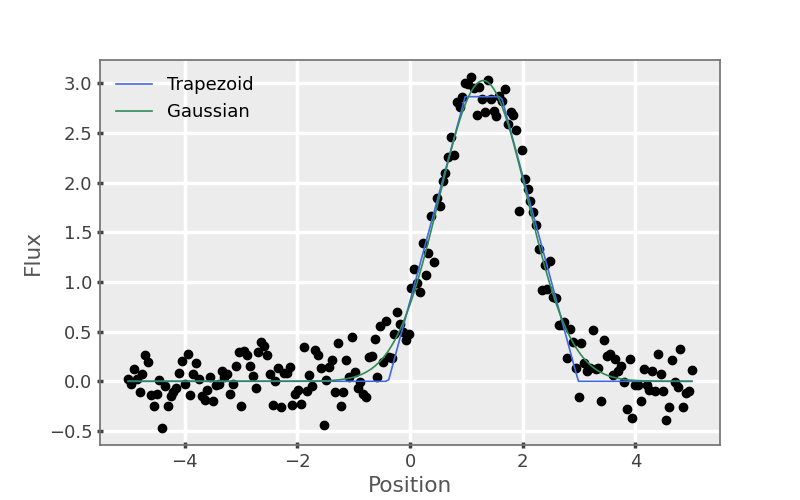

In [14]:
%matplotlib widget # remove this if you don't have widgets
# Gaussian Example
# Generate fake data
rng = np.random.default_rng(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += rng.normal(0., 0.2, x.shape)

# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = amd.models.Trapezoid1D(amplitude=1., x_0=0., width=1., slope=0.5,
                            bounds={"x_0": (-5., 5.)})
fit_t = amd.fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, maxiter=200)

# Fit the data using a Gaussian
g_init = amd.models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = amd.fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.legend(loc=2)
plt.show()

'amplitude: 1000.38579 +- 0.50267'

'x_break: 5.00153 +- 0.00000'

'alpha_1: 0.99941 +- 0.00000'

'alpha_2: 10.04690 +- 0.00147'

'logspace x_break: 4.87871'

'amplitude: 992.86248'

'x_break: 5.00152'

'alpha_1: 0.99941'

'alpha_2: 10.04678'

'delta: 0.00121'

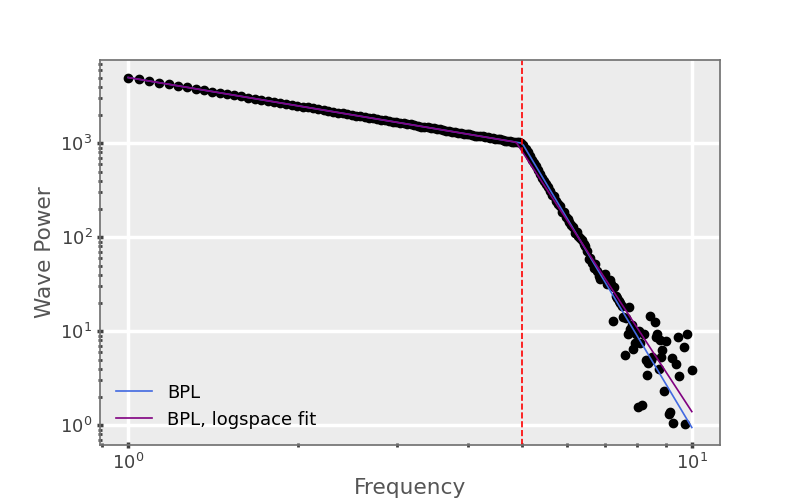

In [134]:
%matplotlib widget
plt.close('all')
# Gaussian Example
# Generate fake data
rng = np.random.default_rng(0)
x = np.linspace(1., 10., 200)


A = 1e3; α1 = 1; α2 = 10; x_br = 5.0;
y = np.zeros(x.shape)
for i in range(0,len(x)):
    if x[i] <= x_br:
        y[i] = A*(x[i]/x_br)**(-α1)
    else:
        y[i] = A*(x[i]/x_br)**(-α2)

# y_log = np.log10(y)
# y_log += rng.normal(0., 0.2, x.shape)
# y = 10**(y_log)

y += rng.normal(0., 5, x.shape)

# Fit the data using a broken power law model.
init = amd.models.BrokenPowerLaw1D(amplitude=A,x_break = x_br,alpha_1=α1,alpha_2=α2)
fit = amd.fitting.LevMarLSQFitter(calc_uncertainties=True)

init2 = (np.log10(A),np.log10(x_br), α1, α2)

p = fit(init, x, y, maxiter=200,filter_non_finite=True)
param_cov = fit.fit_info['param_cov']
# print(fit.fit_info)

# y[1] = np.nan

p2,e2 = BPL_logspace_fit(x, y, init2)

fit_model2 = amd.models.BrokenPowerLaw1D(amplitude = 10**p2[0],x_break=10**p2[1],alpha_1=p2[2],alpha_2=p2[3])


# Fit the data using a smoothly broken power law model.
init3 = amd.models.SmoothlyBrokenPowerLaw1D(amplitude=A,x_break = x_br,alpha_1=α1,alpha_2=α2,delta=0.01,bounds={'delta':(1e-6,None)})
fit = amd.fitting.LevMarLSQFitter(calc_uncertainties=True)


p3 = fit(init3, x, y, maxiter=200,filter_non_finite=True)
param_cov3 = fit.fit_info['param_cov']



# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
# plt.plot(x, y, 'ko')
plt.loglog(x,y,'ko')
plt.plot(x, p(x), label='BPL')
plt.plot(x, fit_model2(x), label='BPL, logspace fit',color='purple')
# plt.plot(x, p3(x), label='sBPL')
plt.axvline(x=p.x_break.value,linestyle='--',color='r')
display(f'{p.amplitude.name}: {p.amplitude.value:.5f} +- {param_cov[0,0]:.5f}')
display(f'{p.x_break.name}: {p.x_break.value:.5f} +- {param_cov[1,1]:.5f}')
display(f'{p.alpha_1.name}: {p.alpha_1.value:.5f} +- {param_cov[2,2]:.5f}')
display(f'{p.alpha_2.name}: {p.alpha_2.value:.5f} +- {param_cov[3,3]:.5f}')

display(f'logspace x_break: {10**p2[1]:.5f}')

display(f'{p3.amplitude.name}: {p3.amplitude.value:.5f}')
display(f'{p3.x_break.name}: {p3.x_break.value:.5f}')
display(f'{p3.alpha_1.name}: {p3.alpha_1.value:.5f}')
display(f'{p3.alpha_2.name}: {p3.alpha_2.value:.5f}')
display(f'{p3.delta.name}: {p3.delta.value:.5f}')


plt.xlabel('Frequency')
plt.ylabel('Wave Power')
plt.legend()
plt.show()

## BPL Fit for Wave Power

Characteristics of a Bad Fit:
* Alpha_1 or alpha_2 are negative values
* Sqrt(Variances) of the Covariance Matrix are close to or larger than the fitted parameter itself

<br> *Note that $R^2$ is not a great measure of goodness of fit in the manner we're looking for*

Questions for Determining a Good/Bad Fit:
* What do we theoretically expect for x_break, alpha_1, alpha_2? Are these easily calculable from wave analysis files
    * alpha_1 is the inertial scale which follows the Kolmogorov Law of a power law of -5/3
    * alpha_2 is the dissipation scale which is "variable and changes depending on plasma conditions such as magnetic energy, anisotropy of the magnetic field fluctuations with respect to the mean magnetic field and bulk plasma velocity, etc." (https://doi.org/10.1098/rsta.2014.0155)
* Is there a physical shape expected for coherent activity? (Could maybe be modelled by a parabola in loglog space or using a second derivative test)

<br> We could use a goodness of fit test for BPL on times with coherent activity when writing filteredActivity files to determine when coherent activity has sufficient power to overcome background turbulent cascade.

PSP_WaveAnalysis_2021-08-09_1800_v1.3.cdf
File exists already
Frequencies does not have an associated epoch
Filtering out incoherent high normal angle data that falls below a coherency of 0.8 and above wave normal angle of 45 deg
Filtering out linear polarization below ellipticity of 0.5 and sorting into rh and lh circular polarization
Trimming top and bottom frequencies by 1.5 Hz
start of time period: 08/09/21 18:00
end of time period: 08/10/21 00:00


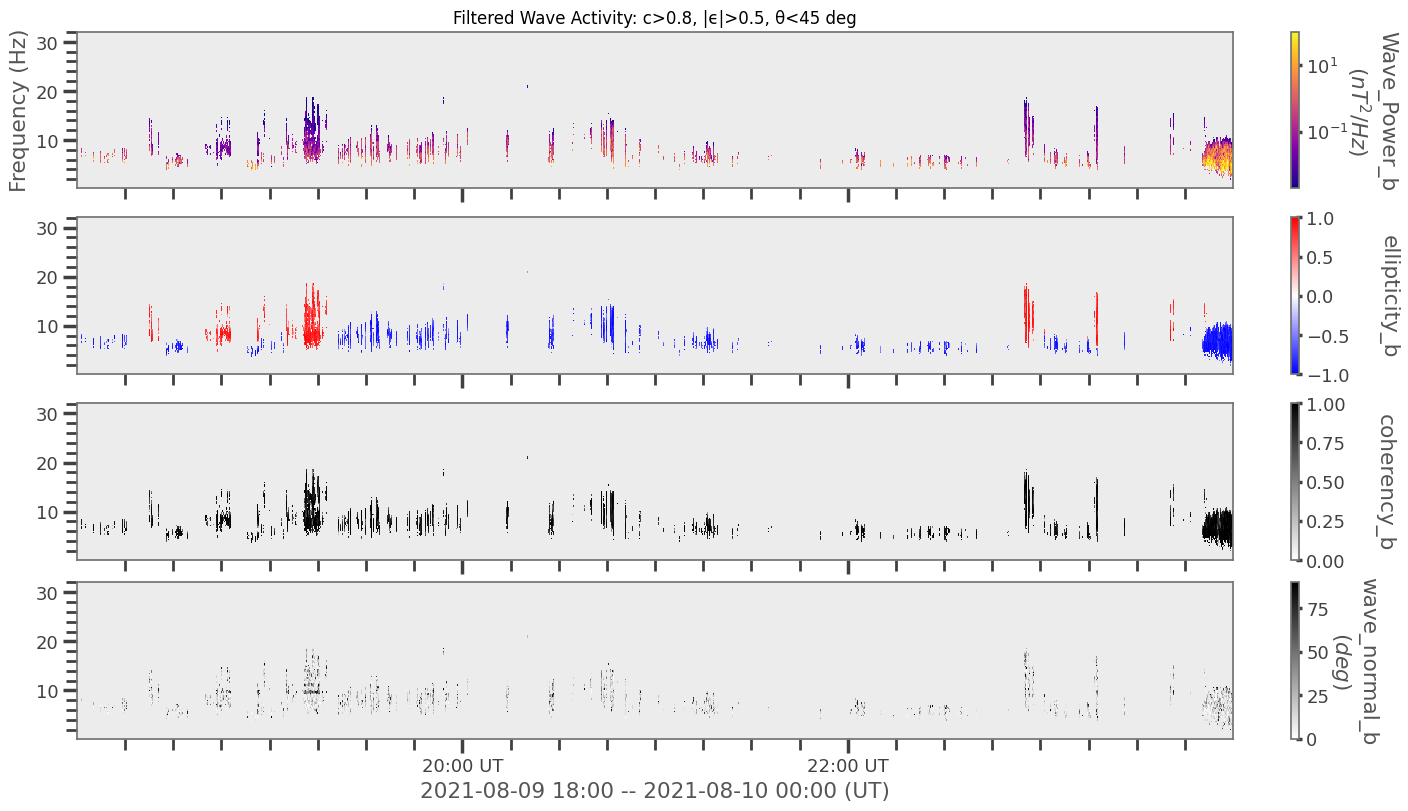

In [15]:
# read in wave analysis and filter a file and display results with a plot
plt.close('all')

date = tz_check(datetime(2021,8,9,18))
coherency_filter = 0.8
circPol_filter = 0.5
waveNormAngle_filter = 45


parameters_list = ['Wave_Power_b','ellipticity_b','coherency_b','wave_normal_b','Bn','Bp','Bq','Frequencies']

filecdf,wave_data,epochs = import_singleWaveAnalysis(date,parameters_list,version = '1.3',datetime_convert=True,
                                                     fileDirectory='Data/',verbose=True)

B_mag = np.linalg.norm(np.array(wave_data[-4:-1]),axis=0)

filter_df,wave_data_filtered = filter_activity(wave_data[:-4],parameters_list[:-4],wave_data[-1],
                                               coherency_filter=coherency_filter,
                                               circPol_filter=circPol_filter,
                                               waveNormAngle_filter=waveNormAngle_filter,
                                              verbose=True)

parameter_limits = [
                    [2e-3,1e2],
                    [filecdf.attget('VALIDMIN',parameters_list[1]).Data,filecdf.attget('VALIDMAX',parameters_list[1]).Data], 
                    [0,1],
                    [0,90]
                           ] 
parameter_log = [True,False,False,False]
parameter_cmap = ['plasma','bwr','binary','binary']
parameter_units = [filecdf.attget('UNITS',param).Data for param in parameters_list[:-1]]
parameter_units[0] = '(nT^2/Hz)' # wave power units
parameter_units[3] = '(deg)'

            
fig,ax = plot_waveActivity(date,date + timedelta(hours=6),parameters_list[:-4],wave_data_filtered,epochs[1],wave_data[-1],
                   parameter_limits,parameter_log,parameter_cmap,parameter_units,
                           show=True,save=False,
                           title=f'Filtered Wave Activity: c>{coherency_filter}, |ϵ|>{circPol_filter}, θ<{waveNormAngle_filter} deg',
                           output_fileBase='filteredParameters',verbose=True
                  )

plt.show()

'amplitude: 0.08601 +- 1.40185'

'x_break: 8.84371 +- 57.37483'

'alpha_1: 2.51156 +- 0.09558'

'alpha_2: 5.65181 +- 136.66329'

R2:  -0.0042123359206986954


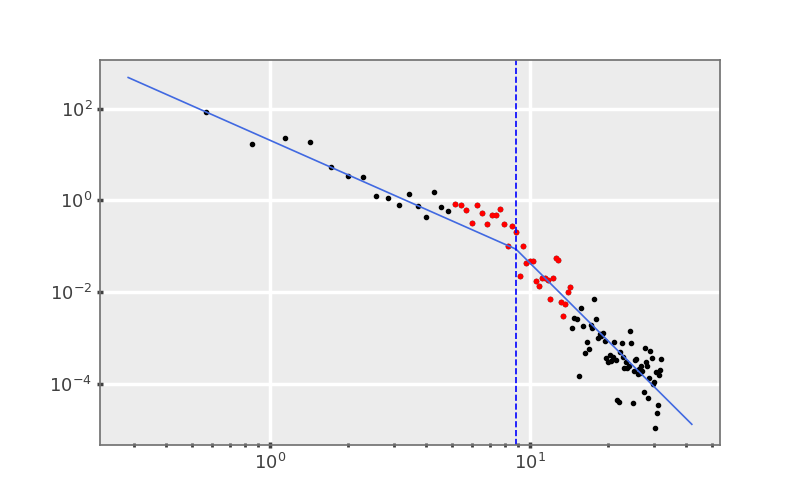

In [71]:
# Good BPL Fit
plt.close()
i = 9949
p, param_cov = BPL_fit(wave_data[-1][1:],wave_data[0][i,1:],init=(0.1,7,1,6),verbose=True)
print('R2: ',R2(wave_data[0][i,:],p(wave_data[-1][:])))

freq = np.linspace(wave_data[-1].min(),wave_data[-1].max()+10,200)

fig_fit,ax_fit = plt.subplots(1,1,figsize=(8,5))
# plt.plot(x, y, 'ko')
ax_fit.loglog(wave_data[-1][1:],wave_data[0][i,1:],'k.')
ax_fit.loglog(wave_data[-1][1:],wave_data_filtered[0][i,1:],'r.')
ax_fit.plot(freq, p(freq), label='BPL')
plt.axvline(x=p.x_break.value,linestyle='--',color='b')

'amplitude: 11.48171 +- 7.72009'

'x_break: 5.70313 +- 1.21545'

'alpha_1: -2.14821 +- 2.87256'

'alpha_2: 5.93935 +- 10.47021'

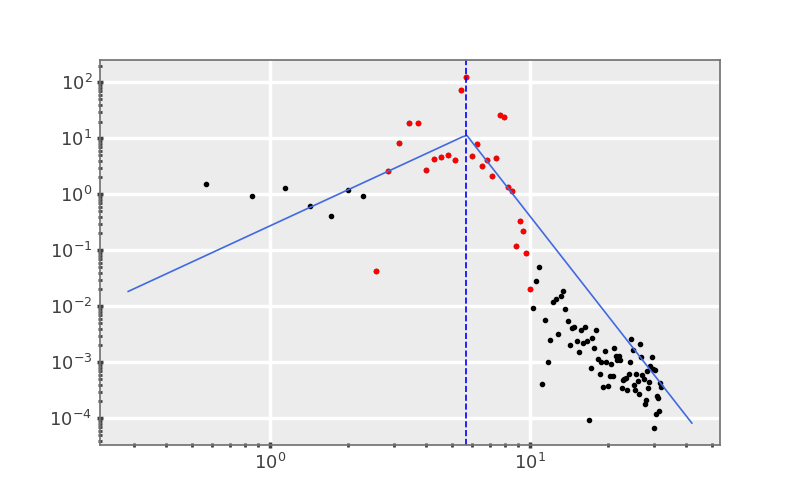

In [32]:
#Bad BPL Fit
plt.close()
i = 49427
p, param_cov = BPL_fit(wave_data[-1][1:],wave_data[0][i,1:],init=(.1,7,1,6),verbose=True)
# print('R2: ',R2(wave_data[0][i,1:],p(wave_data[-1][1:])))
freq = np.linspace(wave_data[-1].min(),wave_data[-1].max()+10,200)

fig_fit,ax_fit = plt.subplots(1,1,figsize=(8,5))

# plt.plot(x, y, 'ko')
ax_fit.loglog(wave_data[-1][1:],wave_data[0][i,1:],'k.')
ax_fit.loglog(wave_data[-1][1:],wave_data_filtered[0][i,1:],'r.')
ax_fit.plot(freq, p(freq), label='BPL')
plt.axvline(x=p.x_break.value,linestyle='--',color='b')
plt.show()

In [26]:
# widget for looking at bpl fits for filtered data.
%matplotlib widget
plt.close()
@widgets.interact(index = (0,wave_data[0].shape[0]-1,1),error_order=['O(h^2)','O(h^4)','O(h^6)'],verbose=False,fit=['f vs P','logspace', 'smooth','noise'],log=['On','Off'],plot_fit=True)

def plot_widget(index = wave_data[0].shape[0]-1,error_order='O(h^2)',verbose=False,fit = 'f vs P',log='On',plot_fit=True):

    error_map = {'O(h^2)':2,'O(h^4)':4,'O(h^6)':6}
    
    plt.close()
    if plot_fit:
        fig2,ax2 = plt.subplots(1,2)
        fig2.set_size_inches(12,4)
        if log is 'On':
        
            ax2[0].loglog(wave_data[-1],wave_data[0][index,:],'k.')
            ax2[0].loglog(wave_data[-1],wave_data_filtered[0][index,:],'r.')
        else:
            ax2[0].plot(wave_data[-1][1:],wave_data[0][index,1:],'k.')
            ax2[0].plot(wave_data[-1][1:],wave_data_filtered[0][index,1:],'r.')
    else:
        fig2,ax2 = plt.subplots(1,1)
        fig2.set_size_inches(14,6)
        if log is 'On':
        
            ax2.loglog(wave_data[-1],wave_data[0][index,:],'k.')
            ax2.loglog(wave_data[-1],wave_data_filtered[0][index,:],'r.')
        else:
            ax2.plot(wave_data[-1][1:],wave_data[0][index,1:],'k.')
            ax2.plot(wave_data[-1][1:],wave_data_filtered[0][index,1:],'r.')
        
    

    try: 
        if plot_fit:
            # f_c = cyclotron_frequency(1,1.6726*10**-24,B_mag[index]*10**(-5))
            # print(f_c)
            # p, param_cov = BPL_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.mean(wave_data[0][index,1:]),f_c,5/3,6),verbose=True)
            # # print(param_cov)
            # freq = np.linspace(wave_data[-1].min(),wave_data[-1].max()+10,200)
            # ax2[0].plot(freq, p(freq), label='BPL')
            # ax2[0].axvline(x=p.x_break.value,linestyle='--',color='b')
    
            # fit with coherent points
            f_c = cyclotron_frequency(1,1.6726*10**-24,B_mag[index]*10**(-5))
            if verbose:
                print(f'f_c: {f_c:.5f} Hz')
                print('Fit With Coherent Points')
    
            freq = np.linspace(wave_data[-1].min(),wave_data[-1].max()+10,200)
            
            if fit is 'logspace':
                p, e = BPL_logspace_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.log10(np.nanmax(wave_data[0][index,1:])),np.log10(f_c),5/3,6),verbose=verbose)
                
                fit_model = amd.models.BrokenPowerLaw1D(amplitude = 10**p[0],x_break=10**p[1],alpha_1=p[2],alpha_2=p[3])
                ax2[0].plot(freq, fit_model(freq), label='log, w/ coh')
                ax2[0].axvline(x=10**p[1],linestyle='--',color='b')
                
            elif fit is 'f vs P': 
    
                p, param_cov = BPL_my_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.nanmax(wave_data[0][index,1:]),f_c,5/3,6),verbose=verbose)
                
                fit_model = amd.models.BrokenPowerLaw1D(amplitude = p[0],x_break=p[1],alpha_1=p[2],alpha_2=p[3])
        
                ax2[0].plot(freq, fit_model(freq), color='b',label='w/ coh')
                ax2[0].axvline(x=p[1],linestyle='--',color='b')
    
            elif fit is 'smooth':
                p, param_cov = BPL_smooth_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.nanmax(wave_data[0][index,1:]),f_c,5/3,6,0.001),verbose=verbose)
                
                ax2[0].plot(freq, p(freq), label='w/ coh')
                ax2[0].axvline(x=p.x_break.value,linestyle='--',color='b')
            elif fit is 'noise':
                p, param_cov = BPL_noise_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.nanmax(wave_data[0][index,1:]),f_c,5/3,6,1e3),verbose=verbose)
        
                def piecewise_power_noise(x, A, x_break, alpha1, alpha2,B):
                    return np.piecewise(x, [x < x_break], [lambda x:A*(x/x_break)**(-alpha1), lambda x:A*(x/x_break)**(-alpha2)+1/B*((B*x-x_break)/x-(B-1))])
                
                fit_model = piecewise_power_noise(x=freq,A = p[0],x_break=p[1],alpha1=p[2],alpha2=p[3],B=p[4])
        
                ax2[0].plot(freq, fit_model, color='b',label='w/ coh')
                ax2[0].axvline(x=p[1],linestyle='--',color='b')
            
            #fit without coherent points
            if verbose:
                print("Fit Without Coherent Points")
            # non_coherent_data = np.where(np.invert(np.isnan(wave_data_filtered[0][index,:])),wave_data[0][index,:],np.nan)
    
            low_frequency_cut = wave_data[-1] <= 20
    
            
    
            
            non_coherent_data = wave_data[0][index,:][low_frequency_cut][np.isnan(wave_data_filtered[0][index,:][low_frequency_cut])]
            non_coherent_freq = wave_data[-1][low_frequency_cut][np.isnan(wave_data_filtered[0][index,:][low_frequency_cut])]
    
            if fit is 'logspace':
                p2, e2 = BPL_logspace_fit(non_coherent_freq[1:],non_coherent_data[1:],init=(np.log10(np.nanmax(non_coherent_data[1:])),np.log10(f_c),5/3,6),verbose=verbose)
                
                fit_model2 = amd.models.BrokenPowerLaw1D(amplitude = 10**p2[0],x_break=10**p2[1],alpha_1=p2[2],alpha_2=p2[3])
                
                ax2[0].plot(freq, fit_model2(freq), label='log, w/o coh',color='purple')
                ax2[0].axvline(x=10**p2[1],linestyle='--',color='purple')
    
            elif fit is 'f vs P': 
    
                p2, param_cov2 = BPL_my_fit(non_coherent_freq[1:],non_coherent_data[1:],init=(np.nanmax(non_coherent_data[1:]),f_c,5/3,6),verbose=verbose)
                
                fit_model2 = amd.models.BrokenPowerLaw1D(amplitude = p2[0],x_break=p2[1],alpha_1=p2[2],alpha_2=p2[3])
        
                ax2[0].plot(freq, fit_model2(freq), color='purple',label='w/o coh')
                ax2[0].axvline(x=p2[1],linestyle='--',color='purple')
    
            elif fit is 'smooth':
                
                p2, param_cov2 = BPL_smooth_fit(non_coherent_freq[1:],non_coherent_data[1:],init=(np.nanmax(non_coherent_data[1:]),f_c,5/3,6,0.001),verbose=verbose)
                ax2[0].plot(freq, p2(freq), color='purple',label='w/o coh')
                ax2[0].axvline(x=p2.x_break.value,linestyle='--',color='purple')
    
            elif fit is 'noise':
                p2, param_cov2 = BPL_noise_fit(non_coherent_freq[1:],non_coherent_data[1:],init=(np.nanmax(non_coherent_data[1:]),f_c,5/3,6,1e3),verbose=verbose)
        
                def piecewise_power_noise(x, A, x_break, alpha1, alpha2,B):
                    return np.piecewise(x, [x < x_break], [lambda x:A*(x/x_break)**(-alpha1), lambda x:A*(x/x_break)**(-alpha2)+1/B*((B*x-x_break)/x-(B-1))])
                
                fit_model2 = piecewise_power_noise(x=freq,A = p2[0],x_break=p2[1],alpha1=p2[2],alpha2=p2[3],B=p2[4])
        
                ax2[0].plot(freq, fit_model2, color='purple',label='w/o coh')
                ax2[0].axvline(x=p2[1],linestyle='--',color='purple')
        else:
            pass
    except:
        print('fit failed')

    # if fit is 'f vs P': 

    #     p2, param_cov2 = BPL_my_fit(non_coherent_freq[1:],non_coherent_data[1:],init=(np.nanmax(non_coherent_data[1:]),f_c,5/3,6),verbose=verbose)
        
    #     fit_model2 = amd.models.BrokenPowerLaw1D(amplitude = p2[0],x_break=p2[1],alpha_1=p2[2],alpha_2=p2[3])

    #     ax2[0].plot(freq, fit_model2(freq), color='purple',label='w/o coh')
    #     ax2[0].axvline(x=p2[1],linestyle='--',color='purple')

    # if fit is 'f vs P':
    #     p, param_cov = BPL_fit(wave_data[-1][1:],wave_data[0][index,1:],init=(np.nanmax(wave_data[0][index,1:]),f_c,5/3,6),verbose=verbose)
        
    #     ax2[0].plot(freq, p(freq), label='w/ coh')
    #     ax2[0].axvline(x=p.x_break.value,linestyle='--',color='b')
    
    if plot_fit:
        # ax2.set_ylim((0,200))
        ax2[0].set_xlabel('Frequency [Hz]')
        ax2[0].set_ylabel('Wave Power [nT^2/Hz]')
        ax2[0].set_title(f"{epochs[1][index].strftime('%Y-%m-%d %H:%M UT')}")
        ax2[0].legend()
    
        # ax2[1].loglog(wave_data[-1][1:],sc.signal.savgol_filter(wave_data[0][index,1:],6,2),'k.')
        
        # secDer = second_diff(wave_data[0][index,1:],wave_data[-1][2]-wave_data[-1][1],error_order=error_map[error_order])
        # ax2[1].semilogx(wave_data[-1][1:],secDer,'k.')
    
        secDer_filter = second_diff(sc.signal.savgol_filter(wave_data[0][index,1:],7,2),wave_data[-1][2]-wave_data[-1][1],error_order=error_map[error_order])
        ax2[1].semilogx(wave_data[-1][1:],secDer_filter,'m-',label='smooth')
        ax2[1].legend()
    
        try:
            if logspace_fit:
                ax2[1].axvline(x=10**p[1],linestyle='--',color='b')
                ax2[1].axvline(x=10**p2[1],linestyle='--',color='purple')
            else:
                ax2[1].axvline(x=p.x_break.value,linestyle='--',color='b')
                ax2[1].axvline(x=p2.x_break.value,linestyle='--',color='purple')
        except:
            pass
        ax2[1].set_xlabel('Frequency [Hz]')
        ax2[1].set_ylabel("Power'' [nT^2/Hz^3]")
        ax2[1].set_title('2nd Derivative of Wave Power')
        
    else:
        ax2.set_xlabel('Frequency [Hz]')
        ax2.set_ylabel(r'Wave Power [$\rm{nT}^2/\rm{Hz}$]')
        ax2.set_title(f"{epochs[1][index].strftime('%Y-%m-%d %H:%M UT')}")
        
    
    fig2.tight_layout()
    plt.show()


interactive(children=(IntSlider(value=49427, description='index', max=49427), Dropdown(description='error_orde…

In [22]:
# 1/f flux gate magnetometer noise + electronic noise --> make a cutoff around ~20 Hz

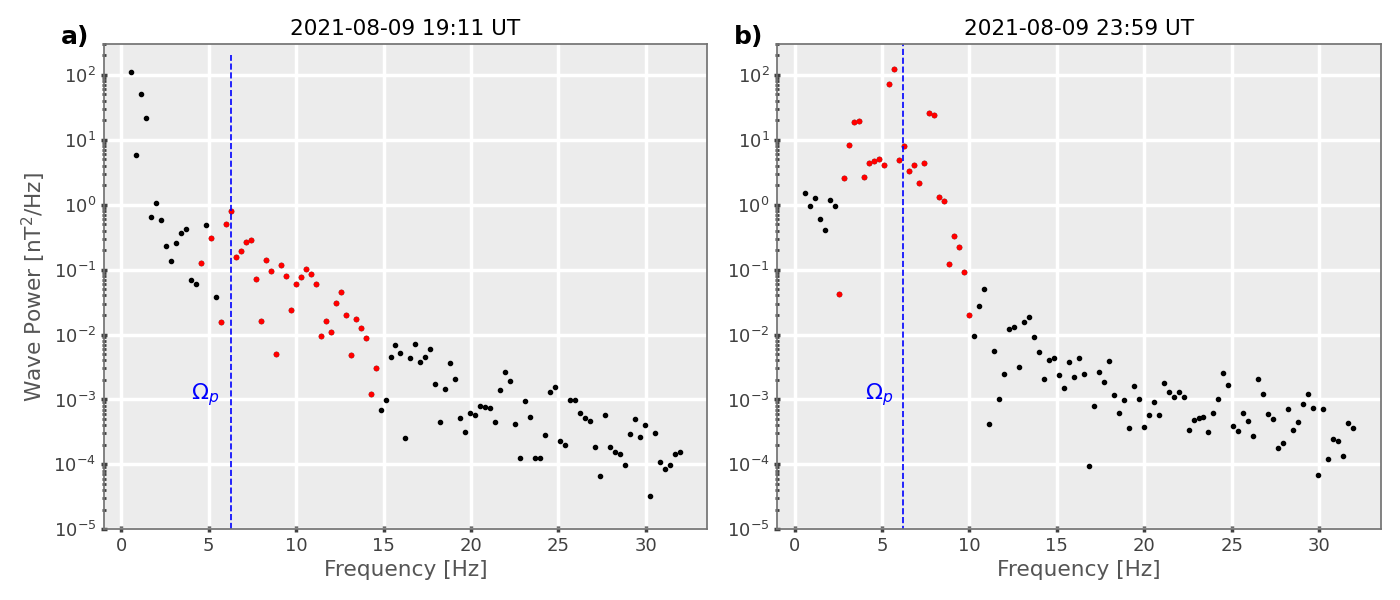

In [49]:
# This is what I used to make the plots in my paper
fig2,ax2 = plt.subplots(1,2)
fig2.set_size_inches(14,6)

index = 9784
f_c = cyclotron_frequency(1,1.6726*10**-24,B_mag[index]*10**(-5))
ax2[0].plot(wave_data[-1][1:],wave_data[0][index,1:],'k.')
ax2[0].plot(wave_data[-1][1:],wave_data_filtered[0][index,1:],'r.')
ax2[0].set_title(f"{epochs[1][index].strftime('%Y-%m-%d %H:%M UT')}")
ax2[0].set_yscale('log')
ax2[0].vlines(f_c,1e-5,2e2,'blue',linestyle='--')
ax2[0].set_ylim([1e-5,3e2])
ax2[0].annotate('$\Omega_p$',(4,1e-3),color='blue',fontsize=16)
ax2[0].annotate('$\mathbf{a)}$',(-3.5,3e2),annotation_clip=False,fontsize=18)



# index = 49420
index = 49427
f_c = cyclotron_frequency(1,1.6726*10**-24,B_mag[index]*10**(-5))
ax2[1].plot(wave_data[-1][1:],wave_data[0][index,1:],'k.')
ax2[1].plot(wave_data[-1][1:],wave_data_filtered[0][index,1:],'r.')
ax2[1].set_title(f"{epochs[1][index].strftime('%Y-%m-%d %H:%M UT')}")
ax2[1].set_yscale('log')
ax2[1].vlines(f_c,9e-6,3e2,'blue',linestyle='--')
ax2[1].set_ylim([1e-5,3e2])
ax2[1].annotate('$\Omega_p$',(4,1e-3),color='blue',fontsize=16)
ax2[1].annotate('$\mathbf{b)}$',(-3.5,3e2),annotation_clip=False,fontsize=18)


ax2[0].set_xlabel('Frequency [Hz]')
ax2[1].set_xlabel('Frequency [Hz]')
ax2[0].set_ylabel(r'Wave Power [$\rm{nT}^2/\rm{Hz}$]')
fig2.tight_layout()
plt.savefig('BPL_cases.png',dpi=300)
# plt.show()